In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import time
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [4]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False, directory = '/home/wolfman/Pictures', return_P=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_ind=[]
    params['u_sol']=u
    #params['ux']=ux
    #params['uy']=uy
    refined=[]
    P=[]
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            fig = plt.figure()
            MP.mesh.draw(fig=fig)
            plt.axis('off')
            plt.axis('scaled');
            plt.savefig(directory + '/i'+str(i)+'.png',bbox_inches='tight')
            plt.close(fig)
            #plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if i < maxiter-1:
            start=time.time()
            err_ind.append(adap.PoissonEstimator(MP,uh,f))
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_marking(err_ind[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            P.append(MP.patch_refine(h_ref=marked_patches, return_P=True))
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_ind, refined, P

In [5]:
def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            MP.mesh.draw(bwidth=1)
            plt.axis('scaled');
            plt.show()
            
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        #Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])
        
        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
            
        if i < maxiter-1:
            start=time.time()
            MP.patch_refine(h_ref=-1)
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    #MP.plot(uh)
        
    return MP, uh, numdofs, L2err, H1err

In [8]:
deg=4
M = Lshape(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
maxiter=5
uh=[]
numdofs = np.zeros(maxiter,dtype=float)
P=[]
return_P = True

for i in range(maxiter):
    print(i)
    bcs = MP.compute_dirichlet_bcs({0:0.})
    Kh = MP.assemble_volume(vform.stiffness_vf(2))
    Mh = MP.assemble_volume(vform.mass_vf(2))
    F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
    LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
    uh.append(LS.complete((cholesky(LS.A))(LS.b)))
    numdofs[i] = MP.numdofs
    print(MP.numdofs)
    
    if i < maxiter-2 :
        P.append(MP.h_refine(h_ref=-1, return_P=return_P))
    elif i == maxiter-2:
        P.append(MP.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err = np.zeros(maxiter)
H1err = np.zeros(maxiter)
for i in range(len(uh)-1):
    eh = P[i]@uh[i]-uh[-1]
    L2err[i] = eh @ Mh @ eh
    H1err[i] = eh @ Kh @ eh + L2err[-1]
L2err = sqrt(np.array(L2err))
H1err = sqrt(np.array(H1err))

Basis setup took 0.007216930389404297 seconds
0
225
Refinement took 0.00015211105346679688 seconds
Basis setup took 0.007802486419677734 seconds
Prolongation took 0.005952119827270508 seconds
1
560
Refinement took 0.00013446807861328125 seconds
Basis setup took 0.013363838195800781 seconds
Prolongation took 0.006669044494628906 seconds
2


/tmp/ipykernel_7168/44596524.py:17: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh.append(LS.complete((cholesky(LS.A))(LS.b)))


1680
Refinement took 0.0004601478576660156 seconds
Basis setup took 0.0341339111328125 seconds
Prolongation took 0.008451223373413086 seconds
3
5720
Basis setup took 0.16021943092346191 seconds
Prolongation took 0.016458511352539062 seconds
4
21000


In [59]:
del Kh

In [64]:
np.c_[[numdofs,H1err,L2err]]

array([[2.25000e+02, 5.60000e+02, 1.68000e+03, 5.72000e+03, 2.10000e+04, 8.03600e+04, 3.14280e+05, 1.24292e+06],
       [1.31863e-02, 8.31226e-03, 5.21803e-03, 3.25848e-03, 2.00661e-03, 1.18778e-03, 6.10579e-04, 0.00000e+00],
       [2.28780e-04, 8.61589e-05, 3.27076e-05, 1.24463e-05, 4.65063e-06, 1.61971e-06, 4.34238e-07, 0.00000e+00]])

In [65]:
np.savetxt('Lp'+str(deg)+'n'+str(deg+1)+'corner_uni.txt', np.c_[[numdofs,H1err,L2err]])

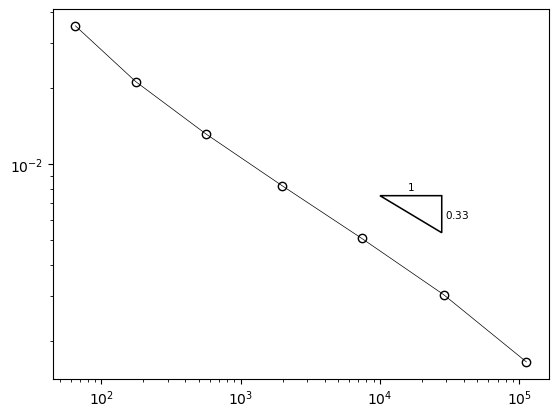

In [7]:
fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
draw_loglog_slope(fig,ax,(1e4,0.75*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

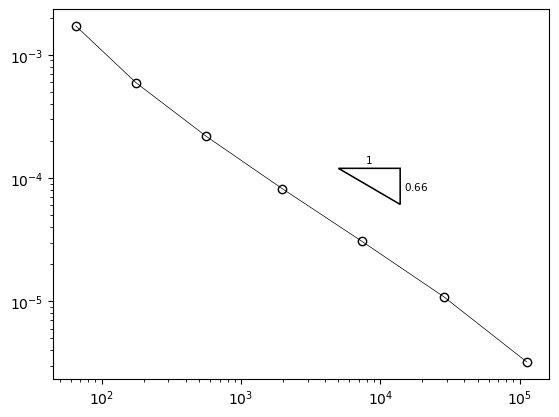

In [8]:
fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
draw_loglog_slope(fig,ax,(5*1e3,0.12*1e-3),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

In [110]:
deg=4
M_a = Lshape(deg,deg+1)
MP_a = assemble.Multipatch(M_a, automatch=True)
uh_a=[]
P_a=[]
err_ind=[]

maxiter=40
numdofs_a =np.zeros(maxiter)
err_est=np.zeros(maxiter)

for i in range(maxiter):
    MP_a.mesh.sanity_check()
    MP_a.sanity_check()
    print(i)
    numdofs_a[i]=MP_a.numdofs
    bcs = MP_a.compute_dirichlet_bcs({0:0.})
    Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
    Mh_a = MP_a.assemble_volume(vform.mass_vf(2))
    F_a = MP_a.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
    LS = assemble.RestrictedLinearSystem(Kh_a, F_a, bcs)
    uh_a.append(LS.complete((cholesky(LS.A))(LS.b)))
    
    if i < maxiter-2 :
        err_ind.append(adap.PoissonEstimator(MP_a,uh_a[i],f={0:lambda x,y: 1.}))
        err_est[i] = norm(err_ind[-1])
        marked_patches = adap.doerfler_marking(err_ind[-1], 0.9)
        marked_patches = {p:None for p in marked_patches}
        P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
        #MP_a.mesh.draw(plt.figure())
    elif i == maxiter-2:
        P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
    else:
        pass
    
for k in reversed(range(1,len(P_a))):
    P_a[k-1]=P_a[k]@P_a[k-1]
    
L2err_a = np.zeros(maxiter)
H1err_a = np.zeros(maxiter)
for i in range(len(uh_a)-1):
    eh = P_a[i]@uh_a[i]-uh_a[-1]
    L2err_a[i] = eh @ Mh_a @ eh
    H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
L2err_a = sqrt(np.array(L2err_a))
H1err_a = sqrt(np.array(H1err_a))

Basis setup took 0.0075647830963134766 seconds
0
Residual contributions took 0.018474102020263672 seconds.
Jump contributions took 0.009425163269042969 seconds.
Refinement took 0.008272886276245117 seconds
Basis setup took 0.013612985610961914 seconds
Prolongation took 0.02223515510559082 seconds
1


/tmp/ipykernel_8220/3407055884.py:22: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh_a.append(LS.complete((cholesky(LS.A))(LS.b)))


Residual contributions took 0.07230377197265625 seconds.
Jump contributions took 0.08150219917297363 seconds.
Refinement took 0.010212898254394531 seconds
Basis setup took 0.020603179931640625 seconds
Prolongation took 0.022339582443237305 seconds
2
Residual contributions took 0.12659215927124023 seconds.
Jump contributions took 0.1768174171447754 seconds.
Refinement took 0.01205301284790039 seconds
Basis setup took 0.033925771713256836 seconds
Prolongation took 0.02234959602355957 seconds
3
Residual contributions took 0.17123031616210938 seconds.
Jump contributions took 0.2796330451965332 seconds.
Refinement took 0.015047073364257812 seconds
Basis setup took 0.04517507553100586 seconds
Prolongation took 0.022334814071655273 seconds
4
Residual contributions took 0.22339797019958496 seconds.
Jump contributions took 0.38522911071777344 seconds.
Refinement took 0.016389846801757812 seconds
Basis setup took 0.057866573333740234 seconds
Prolongation took 0.022862911224365234 seconds
5
Resid

In [111]:
np.savetxt('Lp'+str(deg)+'n'+str(deg+1)+'corner.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

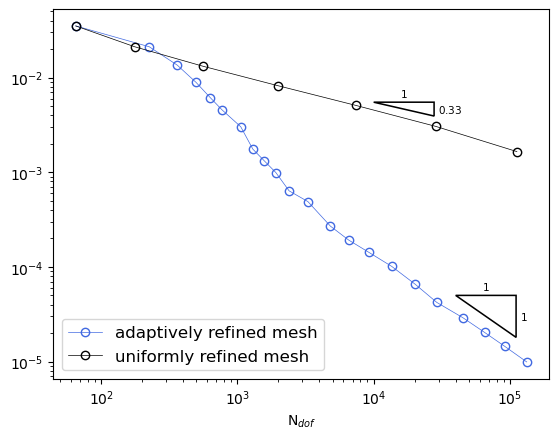

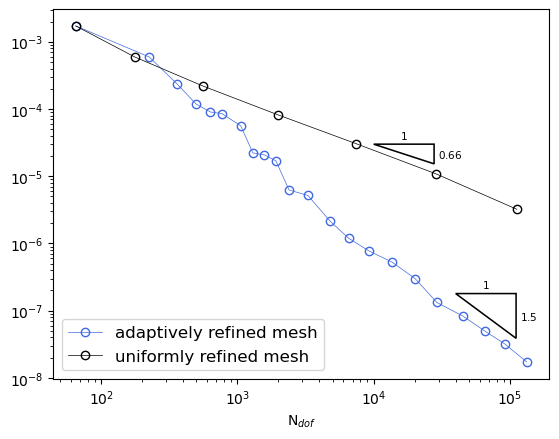

In [76]:
deg=2
[numdofs_a,H1err_a,L2err_a,err_est]=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'corner.txt')
[numdofs,H1err,L2err]=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'corner_uni.txt')
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-2], err_est[:-2], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(4*1e4,0.5*1e-4),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.55*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv_corner.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(4*1e4,1.8*1e-7),2,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,3*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv_corner.pdf', bbox_inches='tight')
plt.show()

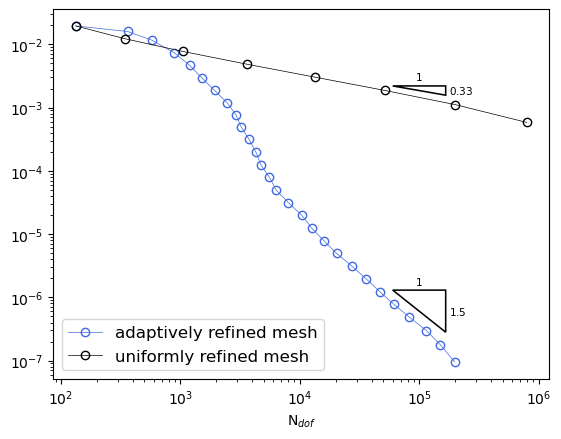

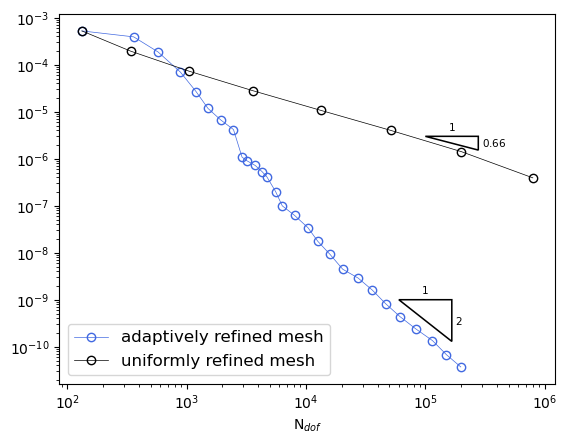

In [103]:
deg=3
[numdofs_a,H1err_a,L2err_a,err_est]=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'corner.txt')
[numdofs,H1err,L2err]=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'corner_uni.txt')
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-2], err_est[:-2], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(6*1e4,1.3*1e-6),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(6*1e4,2.2*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv_corner.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(6*1e4,1e-9),2,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,3*1e-6),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv_corner.pdf', bbox_inches='tight')
plt.show()

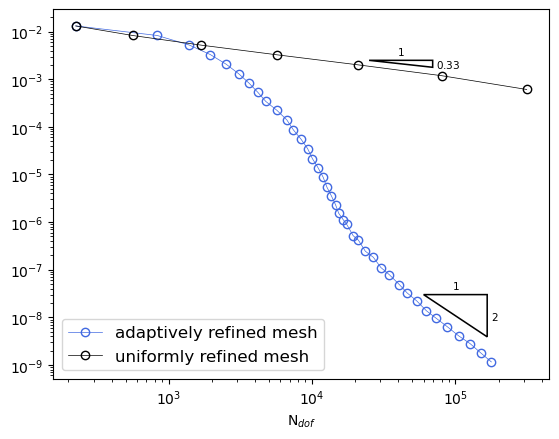

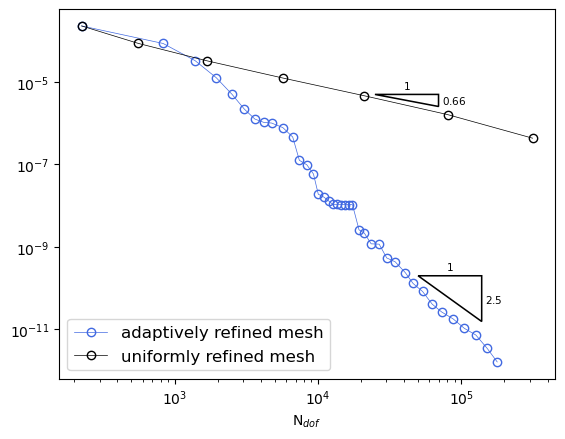

In [138]:
deg=4
[numdofs_a,H1err_a,L2err_a,err_est]=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'corner.txt')
[numdofs,H1err,L2err]=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'corner_uni.txt')
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-2], err_est[:-2], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(6*1e4,3*1e-8),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(2.5*1e4,2.5*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv_corner.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(5*1e4,2*1e-10),2,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(2.5*1e4,5*1e-6),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv_corner.pdf', bbox_inches='tight')
plt.show()

In [69]:
MP_a.mesh.sanity_check()

In [18]:
numdofs_anp.loadtxt("Lp2n3corner.txt")

array([[6.50000e+01, 2.25000e+02, 3.61000e+02, 4.97000e+02, 6.33000e+02, 7.69000e+02, 1.05700e+03, 1.29700e+03, 1.57700e+03, 1.91300e+03, 2.39300e+03, 3.28900e+03, 4.81300e+03, 6.53700e+03, 9.18100e+03, 1.35850e+04, 2.01250e+04, 2.90850e+04, 4.53090e+04, 6.53530e+04, 9.14850e+04, 1.32897e+05, 4.13190e+05],
       [3.51651e-02, 2.11847e-02, 1.35584e-02, 8.88794e-03, 6.11681e-03, 4.57350e-03, 3.02554e-03, 1.75417e-03, 1.31609e-03, 9.92742e-04, 6.36479e-04, 4.89813e-04, 2.69567e-04, 1.92576e-04, 1.42996e-04, 1.01102e-04, 6.57483e-05, 4.21210e-05, 2.89791e-05, 2.02736e-05, 1.45067e-05, 9.90804e-06, 0.00000e+00],
       [1.71948e-03, 5.93418e-04, 2.34674e-04, 1.18466e-04, 9.02741e-05, 8.53600e-05, 5.61973e-05, 2.22410e-05, 2.07724e-05, 1.69656e-05, 6.24517e-06, 5.18396e-06, 2.12525e-06, 1.20125e-06, 7.79346e-07, 5.31264e-07, 3.01402e-07, 1.32722e-07, 8.30550e-08, 4.99678e-08, 3.21995e-08, 1.73289e-08, 0.00000e+00],
       [5.73581e-02, 3.59820e-02, 2.28712e-02, 1.47288e-02, 9.77259e-03, 6.8

In [49]:
del err_ind

In [51]:
del uh_a_